! pip install -U --user hmmlearn

# Example

In [136]:
from __future__ import print_function

import datetime
from datetime import timedelta
import numpy as np
from matplotlib import cm, pyplot as plt
from matplotlib.dates import YearLocator, MonthLocator
try:
    from matplotlib.finance import quotes_historical_yahoo_ochl
except ImportError:
    # For Matplotlib prior to 1.5.
    from matplotlib.finance import (
        quotes_historical_yahoo as quotes_historical_yahoo_ochl
    )

from hmmlearn.hmm import GaussianHMM, GMMHMM

print(__doc__)

Automatically created module for IPython interactive environment


In [146]:
def HMM(stock, start, end, isPrint = False):
    quotes = quotes_historical_yahoo_ochl( stock, start, end)

    # Unpack quotes
    dates = np.array([q[0] for q in quotes], dtype=int)
    close_v = np.array([q[2] for q in quotes])
    volume = np.array([q[5] for q in quotes])[1:]
    open_v = np.array([q[1] for q in quotes])
    high_v = np.array([q[3] for q in quotes])
    low_v = np.array([q[4] for q in quotes])

    diff = np.diff(close_v)
    dates = dates[1:]
    gap = close_v[1:] - open_v[0:(len(open_v)-1)]
    close_v = close_v[1:]
    open_v =open_v[1:]
    diff_op = np.diff(open_v)
    high_v = high_v[1:]
    low_v = low_v[1:]

    # quotes
#     X = np.column_stack([diff, volume]) 
    X = np.column_stack([diff,close_v, open_v, high_v,low_v]) 
    # Make an HMM instance and execute fit
    model = GaussianHMM(n_components=4, covariance_type="diag", n_iter=1000).fit(X)
    
#     model = GMMHMM(n_components=4, n_mix=10, covariance_type='diag').fit(X)
    
    # Predict the optimal sequence of internal hidden state
    hidden_states = model.predict(X)
    
#     isPrint = False
    if isPrint:
        print("Transition matrix")
        print(model.transmat_)
        print()

        print("Means and vars of each hidden state")
        for i in range(model.n_components):
            print("{0}th hidden state".format(i))
            print("mean = ", model.means_[i])
            print("var = ", np.diag(model.covars_[i]))
            print()
            
        fig, axs = plt.subplots(model.n_components, sharex=True, sharey=True)
        colours = cm.rainbow(np.linspace(0, 1, model.n_components))

        #print(colours)
        for i, (ax, colour) in enumerate(zip(axs, colours)):
            # Use fancy indexing to plot data in each state.
            mask = hidden_states == i
            ax.plot_date(dates[mask], close_v[mask], ".-", c=colours[i])
            ax.set_title("{0}th hidden state".format(i))

            # Format the ticks.
            ax.xaxis.set_major_locator(YearLocator())
            ax.xaxis.set_minor_locator(MonthLocator())
            ax.grid(True)

        plt.show()
    
    
    Zn_post = model.predict_proba(X)[-1]
    Zn1Zn = (model.transmat_.T * Zn_post).T
    Zn1_post = np.sum(Zn1Zn, axis = 0)
    
    x = np.linspace(-100,100,1000000)
    if isPrint:
        plt.plot(x,mix_normal(model, x, Zn1_post))
    predict = x[np.argmax(mix_normal(model, x, Zn1_post))]
    
    return predict+close_v[-1]

import scipy.stats as sp
def mix_normal(model, x,Zn1_post):
    r = 0
    for i in range(4):
        r += sp.norm.pdf(x,model.means_[i][0],model.covars_[i][0,0])*Zn1_post[i]
    return r


In [147]:
def MSE(df, df_true):
    output = []
    for i in range(df.shape[1]):
        output.append(sum((df.ix[:,i]- df_true.ix[:,i])**2)/df.shape[1])
    return output

# GOOGLE

Transition matrix
[[  5.97322782e-001   3.37265391e-070   2.26504412e-001   1.76172806e-001]
 [  1.63481913e-001   6.61148205e-001   1.48653467e-112   1.75369882e-001]
 [  4.14367163e-001   3.89742239e-127   5.85632837e-001   1.18307643e-059]
 [  1.58617872e-001   1.07485328e-001   5.24356978e-103   7.33896800e-001]]

Means and vars of each hidden state
0th hidden state
mean =  [ -2.46704452e-01   7.07464719e+02   7.09663094e+02   7.16364628e+02
   6.99162074e+02]
var =  [ 134.73265729   44.80461488   85.16235532   56.74368535   40.84604464]

1th hidden state
mean =  [  -1.36546886  747.27599768  755.41886271  761.71943204  741.80301404]
var =  [ 247.03408826  111.02988443  220.344372    190.81141233  152.10580427]

2th hidden state
mean =  [  -4.18220323  689.2739909   688.09970582  699.84474058  678.79718911]
var =  [  95.52137999   52.2268439   120.06301498   49.91114654   65.1318673 ]

3th hidden state
mean =  [   3.97350273  733.7579354   730.98678804  738.35089801  726.13863504]


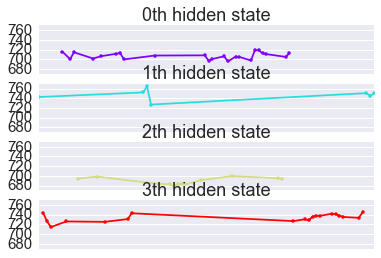

751.85887494890198

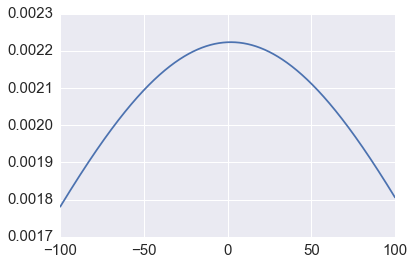

In [148]:
HMM('GOOG', datetime.datetime(2016,1,1), datetime.datetime(2016,4,1),True)

# LinkedIn

In [121]:
# HMM('LNKD', datetime.datetime(2016,3,31)-timedelta(211), datetime.datetime(2016,3,31),True)

# 7 Company

In [165]:
import pandas as pd
from pandas import Series, DataFrame
from datetime import timedelta

In [166]:
company = ["AAPL","FB","LNKD","AMZN","GOOG","MSFT","BABA"]
numdays = 30
base = datetime.datetime(2016,4,30)
preDate = [base - datetime.timedelta(days=x) for x in range(0, numdays)]

In [167]:
# true data
df_true =DataFrame(index = preDate, columns = company)
for date in preDate:
    for comp in company:
        true = quotes_historical_yahoo_ochl(comp, date, date)
        if true is None:
            df_true[comp][date] = None
        else:
#             print()
            df_true[comp][date] = true[0][2]
            

df_true.head()

,AAPL,FB,LNKD,AMZN,GOOG,MSFT,BABA
2016-04-30,None,None,None,None,None,None,None
2016-04-29,93.74,117.58,125.31,659.59,693.01,49.87,76.94
2016-04-28,94.83,116.73,123.01,602,691.02,49.9,76.4
2016-04-27,97.82,108.89,118.85,606.57,705.84,50.94,77.65
2016-04-26,104.35,108.76,122.53,616.88,708.14,51.44,78.61


In [168]:
trueDate = np.array([preDate[i] for i,check in enumerate(df_true.ix[:,1]) if not check is None])
df_true= df_true.ix[trueDate,:]
df = DataFrame(index = trueDate, columns = company)

In [169]:
trueDate[0:2]

array([datetime.datetime(2016, 4, 29, 0, 0),
       datetime.datetime(2016, 4, 28, 0, 0)], dtype=object)

In [170]:
#test

dff = DataFrame(index = trueDate, columns = ['GOOG'])
for date in trueDate:
    dff['GOOG'][date] = HMM('GOOG', date-timedelta(211), date-timedelta(1))


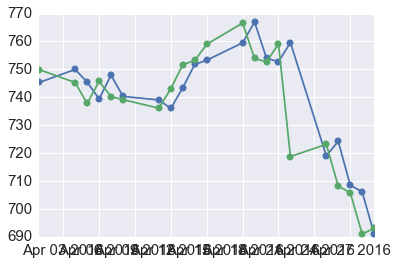

In [172]:
fig, ax = plt.subplots()
ax.plot_date(trueDate, dff['GOOG'][trueDate], marker='o', linestyle='-')
ax.plot_date(trueDate, df_true['GOOG'][trueDate], marker='o', linestyle='-')

In [173]:
for date in trueDate:
    for comp in company:
        df[comp][date] = HMM(comp, date-timedelta(211), date-timedelta(1))
df.head(10)

,AAPL,FB,LNKD,AMZN,GOOG,MSFT,BABA
2016-04-29,94.6461,117.004,121.816,604.128,691.033,49.7645,76.4413
2016-04-28,97.6813,108.986,117.562,608.809,706.128,50.8377,77.7231
2016-04-27,104.259,108.846,121.284,619.353,708.515,51.4653,78.7103
2016-04-26,105.01,110.218,119.175,628.909,724.217,52.1455,78.9491
2016-04-25,105.619,110.815,118.101,623.099,719.739,51.8187,79.9469
2016-04-22,105.903,113.73,119.105,633.871,759.611,55.8595,80.8541
2016-04-21,107.09,112.689,115.878,635.925,753.063,55.6677,81.3909
2016-04-20,106.857,112.538,113.913,630.721,754.016,56.4817,79.6061
2016-04-19,107.306,110.663,116.514,638.415,766.951,56.5543,79.1473
2016-04-18,109.731,109.833,115.066,628.69,759.537,55.7323,79.1097


In [131]:
df.to_csv('predict_hmm_5.csv')

In [174]:
df_true.head(10)

,AAPL,FB,LNKD,AMZN,GOOG,MSFT,BABA
2016-04-29,93.74,117.58,125.31,659.59,693.01,49.87,76.94
2016-04-28,94.83,116.73,123.01,602,691.02,49.9,76.4
2016-04-27,97.82,108.89,118.85,606.57,705.84,50.94,77.65
2016-04-26,104.35,108.76,122.53,616.88,708.14,51.44,78.61
2016-04-25,105.08,110.1,120.48,626.2,723.15,52.11,78.84
2016-04-22,105.68,110.56,119.45,620.5,718.77,51.78,79.89
2016-04-21,105.97,113.44,120.46,631,759.14,55.78,80.78
2016-04-20,107.13,112.42,117.32,632.99,752.67,55.59,81.21
2016-04-19,106.91,112.29,115.42,627.9,753.93,56.39,79.46
2016-04-18,107.48,110.45,118,635.35,766.61,56.46,79.01


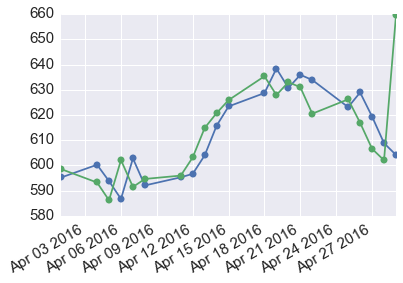

In [175]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.plot_date(trueDate, df['AMZN'][trueDate], marker='o', linestyle='-')
ax.plot_date(trueDate, df_true['AMZN'][trueDate], marker='o', linestyle='-')

fig.autofmt_xdate()
plt.show()

In [176]:
DataFrame(df_true['GOOG'])

,GOOG
2016-04-29,693.01
2016-04-28,691.02
2016-04-27,705.84
2016-04-26,708.14
2016-04-25,723.15
2016-04-22,718.77
2016-04-21,759.14
2016-04-20,752.67
2016-04-19,753.93
2016-04-18,766.61


In [177]:
MSE(df, df_true)

[11.414535729577549,
 16.172048745092535,
 30.573684773793794,
 640.93834953312762,
 399.20437429951738,
 3.164896976757094,
 2.7810301809675053]

In [116]:
dff-DataFrame(df_true['GOOG'])

,GOOG
2016-04-29,2.13011
2016-04-28,-0.453881
2016-04-27,2.71454
2016-04-26,-0.623657
2016-04-25,1.43134
2016-04-22,34.6187
2016-04-21,-1.09752
2016-04-20,-2.34611
2016-04-19,-1.01372
2016-04-18,0.18848


$P(Z_n | x_1 \dots, x_n) $

In [296]:
Zn_post = model.predict_proba(X)[-1]

$P(Z_{n+1}, Z_{n} | X_1, \dots, X_n) = P(Z_{n+1} | Z_n) * P(Z_n | x_1 \dots, x_n)$

In [297]:
Zn1Zn = (model.transmat_.T * Zn_post).T

$P(Z_{n+1} | X_1, \dots, X_n) = \sum_{i=1}^{4} P(Z_{n+1}, Z_{n} =i | X_1, \dots, X_n) $

In [298]:
Zn1_post = np.sum(Zn1Zn, axis = 0)

In [299]:
Zn1_post 

array([  5.96671768e-05,   3.27469809e-01,   4.40764272e-02,
         6.28394096e-01])

In [30]:
test = quotes_historical_yahoo_ochl(
    "AAPL", datetime.date(2016, 4, 1), datetime.date(2016, 4, 2))

In [31]:
test

[(736055.0, 108.779999, 109.989998, 110.0, 108.199997, 25626200.0)]